In [ ]:
!python -m pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pykalman import KalmanFilter
from sklearn.impute import KNNImputer
import time as time
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def create_lagged_features(series, lag=10):
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i + lag])
        y.append(series[i + lag])
    return np.array(X), np.array(y)

In [ ]:
def modified_smape(y_true, y_pred):
    """
    Modified Symmetric Mean Absolute Percentage Error (sMAPE) hesaplama fonksiyonu.

    Parameters:
    y_true (array-like): Gerçek değerler.
    y_pred (array-like): Tahmin edilen değerler.

    Returns:
    float: Modified sMAPE değeri.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Denominator'i hesapla ve sıfır değerleri kaldır
    denominator = np.abs(y_true) + np.abs(y_pred)
    non_zero_indices = denominator != 0

    y_true_non_zero = y_true[non_zero_indices]
    y_pred_non_zero = y_pred[non_zero_indices]
    denominator_non_zero = denominator[non_zero_indices]

    # Modified sMAPE hesaplama
    smape_values = 2 * np.abs(y_true_non_zero - y_pred_non_zero) / denominator_non_zero

    return np.mean(smape_values) * 100

In [ ]:
def zero_imputation(univariate_data_train,univariate_data_test):
    train_univariate_data_imputed = np.nan_to_num(univariate_data_train, nan=0)
    test_univariate_data_imputed=np.nan_to_num(univariate_data_test, nan=0)
    return train_univariate_data_imputed,test_univariate_data_imputed

def mean_imputation(univariate_data_train,univariate_data_test):
    mean_value = np.nanmean(univariate_data_train)  # NaN değerleri hariç ortalama hesapla
    train_univariate_data_imputed = np.where(np.isnan(univariate_data_train), mean_value, univariate_data_train)  # NaN olanları ortalama ile değiştir
    test_univariate_data_imputed= np.where(np.isnan(univariate_data_test), mean_value, univariate_data_test)
    return train_univariate_data_imputed,test_univariate_data_imputed

def random_imputation(univariate_data_train,univariate_data_test):
    valid_values = univariate_data_train[~np.isnan(univariate_data_train)]  # NaN olmayan değerleri seç
    if len(valid_values) == 0:
        return univariate_data_train  # Eğer tüm değerler NaN ise değiştirme
    random_values = np.random.choice(valid_values, size=np.isnan(univariate_data_train).sum())  # Rastgele değerler seç
    train_univariate_data_imputed = np.copy(univariate_data_train)
    train_univariate_data_imputed[np.isnan(univariate_data_train)] = random_values

    test_univariate_data_imputed=np.copy(univariate_data_test)
    valid_values_test = univariate_data_test[~np.isnan(univariate_data_test)]  # NaN olmayan değerleri seç
    mask_test = np.isnan(test_univariate_data_imputed)
    if len(valid_values_test) == 0:
        return univariate_data_test  # Eğer tüm değerler NaN ise değiştirme
    random_values_test = np.random.choice(valid_values, size=np.isnan(univariate_data_test).sum())  # trainden Rastgele değerler seç

    test_univariate_data_imputed[mask_test] = np.random.choice(valid_values, size=mask_test.sum(), replace=True)

    return train_univariate_data_imputed,test_univariate_data_imputed
def median_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri medyan (median) ile doldurur.
    """
    median_value = np.nanmedian(univariate_data_train)  # NaN değerleri hariç medyan hesapla
    train_univariate_data_imputed = np.where(np.isnan(univariate_data_train), median_value, univariate_data_train)
     # NaN olanları medyan ile değiştir
    test_univariate_data_imputed= np.where(np.isnan(univariate_data_test), median_value, univariate_data_test) #trainin mediani ile doldur
    return train_univariate_data_imputed,test_univariate_data_imputed
def forward_fill_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri kendinden önce gelen ilk bilinen değerle doldurur.
    Eğer ilk değerler de NaN ise, dizideki ilk bilinen değeri alıp doldurur.
    """
    train_univariate_data_imputed = np.copy(univariate_data_train)
    mask = np.isnan(train_univariate_data_imputed)

    # Ardışık NaN'leri forward fill ile doldur
    for i in range(1, len(train_univariate_data_imputed)):
        if mask[i]:
            train_univariate_data_imputed[i] = train_univariate_data_imputed[i - 1]  # Önceki bilinen değeri ata

    # Eğer hala NaN kalan değerler varsa, bunları ilk bilinen değer ile doldur
    first_valid_idx = np.where(~mask)[0][0] if np.any(~mask) else None
    if first_valid_idx is not None:
        train_univariate_data_imputed[np.isnan(train_univariate_data_imputed)] = train_univariate_data_imputed[first_valid_idx]



    test_univariate_data_imputed = np.copy(univariate_data_test)
    mask = np.isnan(test_univariate_data_imputed)

    # Ardışık NaN'leri forward fill ile doldur
    for i in range(1, len(test_univariate_data_imputed)):
        if mask[i]:
            test_univariate_data_imputed[i] = test_univariate_data_imputed[i - 1]  # Önceki bilinen değeri ata

    # Eğer hala NaN kalan değerler varsa, bunları ilk bilinen değer ile doldur
    first_valid_idx = np.where(~mask)[0][0] if np.any(~mask) else None
    if first_valid_idx is not None:
        test_univariate_data_imputed[np.isnan(test_univariate_data_imputed)] = train_univariate_data_imputed[-1] #trainin son değeri ile doldur

    return train_univariate_data_imputed,test_univariate_data_imputed
def backward_fill_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri kendinden sonraki ilk bilinen değerle doldurur.
    Eğer son değerler de NaN ise, dizideki son bilinen değeri alıp doldurur.
    """
    train_univariate_data_imputed = np.copy(univariate_data_train)
    mask = np.isnan(train_univariate_data_imputed)


    # Ardışık NaN'leri backward fill ile doldur
    for i in range(len(train_univariate_data_imputed) - 2, -1, -1):
        if mask[i]:
            train_univariate_data_imputed[i] = train_univariate_data_imputed[i + 1]  # Sonraki bilinen değeri ata

    # Son bilinen değeri bul
    last_valid_idx = np.where(~mask)[0][-1] if np.any(~mask) else None

    # Eğer son değerler NaN ise, son bilinen değeri ile doldur
    if last_valid_idx is not None:
        train_univariate_data_imputed[last_valid_idx + 1:] = train_univariate_data_imputed[last_valid_idx]

    test_univariate_data_imputed = np.copy(univariate_data_test)
    mask = np.isnan(univariate_data_test)


    # Ardışık NaN'leri backward fill ile doldur
    for i in range(len(test_univariate_data_imputed) - 2, -1, -1):
        if mask[i]:
            test_univariate_data_imputed[i] = test_univariate_data_imputed[i + 1]  # Sonraki bilinen değeri ata

    # Son bilinen değeri bul
    last_valid_idx = np.where(~mask)[0][-1] if np.any(~mask) else None

    # Eğer son değerler NaN ise, son bilinen değeri ile doldur
    if last_valid_idx is not None:
        test_univariate_data_imputed[last_valid_idx + 1:] = train_univariate_data_imputed[-1]  #trainin son değeri ile doldur

    return train_univariate_data_imputed,test_univariate_data_imputed

def interpolation_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri doğrusal interpolasyon ile doldurur.
    """
    series_data = pd.Series(univariate_data_train)
    train_univariate_data_imputed = series_data.interpolate(method='linear', limit_direction='both').to_numpy()


    combined_data = np.concatenate([univariate_data_train, univariate_data_test])  # Train + Test birleştirildi

    # Birleştirilmiş seriyi oluştur ve interpolasyon uygula
    combined_series = pd.Series(combined_data)
    combined_imputed = combined_series.interpolate(method='linear', limit_direction='both').to_numpy()

    # Sadece Test Setini Çıkar
    test_univariate_data_imputed = combined_imputed[len(univariate_data_train):]  # Test kısmını çek

    return train_univariate_data_imputed, test_univariate_data_imputed

def kalman_filter_imputation(univariate_data_train,univariate_data_test):
    """
    NumPy array içindeki NaN (eksik) değerleri Kalman Filtresi ile doldurur.
    """
    n = len(univariate_data_train)
    mask = np.isnan(univariate_data_train)

    # Kalman Filtresi başlat
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1, initial_state_covariance=1,
                      transition_matrices=[1], observation_matrices=[1],
                      transition_covariance=1, observation_covariance=1)

    # NaN olmayan değerleri belirle
    observations = np.ma.array(univariate_data_train, mask=mask)

    # Kalman filtresini uygula
    train_univariate_data_imputed, _ = kf.smooth(observations)


    combined_data = np.concatenate([univariate_data_train, univariate_data_test])

    # NaN olan gözlemleri maskele
    mask = np.isnan(combined_data)


    # Eksik verileri maskeliyoruz
    observations = np.ma.array(combined_data, mask=mask)

    # Kalman filtresini uygula
    imputed_data, _ = kf.smooth(observations)

    # Train ve Test Setlerini Ayır
    test_univariate_data_imputed = imputed_data[len(univariate_data_train):]

    return train_univariate_data_imputed.flatten(),test_univariate_data_imputed.flatten()

from sklearn.svm import SVR
def svr_imputation_separate(train, test, n_lags=3):
    def create_lagged_df(series):
        df = pd.DataFrame({'y': series})
        for i in range(1, n_lags + 1):
            df[f'lag_{i}'] = df['y'].shift(i)
        return df

    feature_names = [f'lag_{i}' for i in range(1, n_lags + 1)]
    train_df = create_lagged_df(pd.Series(train)).dropna()
    X_train = train_df[feature_names].to_numpy()
    y_train = train_df['y'].to_numpy()
    svr = SVR().fit(X_train, y_train)

    train_filled = np.copy(train)
    for idx in np.where(np.isnan(train))[0]:
        if idx >= n_lags and not np.isnan(train[idx - n_lags:idx]).any():
            x_pred = train[idx - n_lags:idx][::-1].reshape(1, -1)
            train_filled[idx] = svr.predict(x_pred)[0]
    train_filled = pd.Series(train_filled).interpolate().bfill().ffill().to_numpy()

    test_filled = np.copy(test)
    for idx in np.where(np.isnan(test))[0]:
        full_input = np.concatenate([train_filled[-n_lags:], test[:idx]])
        if len(full_input) >= n_lags and not np.isnan(full_input[-n_lags:]).any():
            x_pred = full_input[-n_lags:][::-1].reshape(1, -1)
            test_filled[idx] = svr.predict(x_pred)[0]
    test_filled = pd.Series(test_filled).interpolate().bfill().ffill().to_numpy()
    return train_filled, test_filled


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np
def svr_grid_search(X,y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

      # Hiperparametre arama aralıkları
    param_grid = {
    'C': [1, 10, 100],  # Çok küçük ve çok büyük C değerlerini çıkardık
    'epsilon': [0.01, 0.1],  # Yüksek epsilon değerleri genellikle tahmin doğruluğunu düşürür
    'kernel': ['rbf'],  # Sadece RBF kernel kullanıyoruz
    'gamma': ['scale', 0.1]  # Sadece "scale" ve makul bir sabit değer kullanıyoruz
    }

    # SVR Modeli
    svr = SVR()

    # Grid Search CV
    grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # En iyi model ve hiperparametreler
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print("En iyi parametreler:", best_params)
    return  best_params

In [ ]:
results=[]
results.append(["Dataset","Imputation method","Imputation Time (train+test)","train time","Train MSE","Train MAE","Train RMSE","Train MS_MAPE","test time","Test MSE","Test MAE","Test RMSE","Test MS_MAPE","best paramater ARIMA"])

"""
dataset_names_eskisehir=["MS_missing_with_existing_25pct.xlsx",
                         "CB_missing_with_existing_25pct.xlsx",
                         "Odunpazari_missing_with_existing_25pct.xlsx",
                         "Visnepark_missing_with_existing_25pct.xlsx",
                         "Tepebasi_missing_with_existing_25pct.xlsx"]


dataset_names_eskisehir=["VNS_Odunpazari.xlsx",
               "VNS_Metin_Sonmez.xlsx",
               "VNS_Visnepark.xlsx",
               "VNS_Tepebasi.xlsx",
               "VNS_Cumhuriyet_Bulvari.xlsx"]
"""
dataset_names_eskisehir=["Visnepark_Missing_Original.xlsx"]


imputation_methods = [
        zero_imputation,
        mean_imputation,
        median_imputation,
        forward_fill_imputation,
        backward_fill_imputation,
        interpolation_imputation,
        kalman_filter_imputation,
        svr_imputation_separate]





#imputation_methods=[random_imputation]



for name in dataset_names_eskisehir:
  #dataset_df=pd.read_csv("/content/drive/MyDrive/akademik çalışmalar/In progress/missing data in time series/VNS_dataset/"+name)
  dataset_df=pd.read_excel("/content/drive/MyDrive/eksik_veri_simulasyonlari/"+name)
  dataset_df.replace("-",np.nan,inplace=True)
  #dataset_df = dataset_df.iloc[18630:]
  print(dataset_df.head())
  dataset=dataset_df.iloc[:,1].to_numpy()
  data=dataset
  # NaN olmayan değerleri filtrele
  #data = dataset[~np.isnan(dataset)]
  # ACF grafiğini çiz
  #plot_acf(data, lags=100)  # İlk 100 gecikmeyi göster
  #plt.show()


  # %80 ve %20 oranlarını belirle
  split_index = int(len(data) * 0.8)

  # Eğitim (Train) ve Test bölümleri
  train_data = data[:split_index]  # İlk %80
  test_data = data[split_index:]   # Son %20
  orig_mask_test = ~np.isnan(test_data)
  orig_mask_train = ~np.isnan(train_data)
  lag=24





  for method  in imputation_methods:
    start_imputation_time=time.time()
    print(method)
    imputed_train_full,imputed_test_full = method(np.copy(train_data),np.copy(test_data))
    stop_imputation_time=time.time()


    test_data_copy = np.copy(test_data)
    test_nan_mask = np.isnan(test_data_copy)
    final_test_imputed = np.copy(test_data_copy)
    final_test_imputed[test_nan_mask] = imputed_test_full[test_nan_mask]
    imputed_test = final_test_imputed  # Bundan sonra imputed_test kullanılacak

    train_data_copy = np.copy(train_data)
    train_nan_mask = np.isnan(train_data_copy)
    final_train_imputed = np.copy(train_data_copy)
    final_train_imputed[train_nan_mask] = imputed_train_full[train_nan_mask]
    imputed_train = final_train_imputed  # Bundan sonra imputed_train kullanılacak
    if np.isnan(imputed_train).sum()>0 or np.isnan(imputed_test).sum()>0:
      print("there are missing values in data")
      break

    X_train, y_train = create_lagged_features(imputed_train, lag)
    X_test, y_test = create_lagged_features(imputed_test, lag)
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    best_params=svr_grid_search(X_train_scaled,y_train_scaled)

    best_svr = SVR(**best_params)
    #best_svr=SVR()
    training_time_start=time.time()
    best_svr.fit(X_train_scaled, y_train_scaled)


    training_time_end=time.time()
    training_time=training_time_end-training_time_start

    # 📌 **7. Tahmin Yapma**
    test_start = time.time()
    y_pred_scaled = best_svr.predict(X_test_scaled)
    test_end = time.time()
    testPredict = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    # missing value olmayanlardan üzerinden mterik hesaplarken lage göre düzenleme yapmak lazım
    # 📌 **8. Model Performansını Değerlendirme**

    msmape = modified_smape(y_test, testPredict)



    trainPredict_scaled = best_svr.predict(X_train_scaled)
    trainPredict = scaler_y.inverse_transform(trainPredict_scaled.reshape(-1, 1)).flatten()


    print(len(X_train_scaled),len(X_train),len(imputed_train))
    orig_mask_train_lagged = orig_mask_train[lag:]  # İlk `lag` gözlem doğal olarak kaybolduğu için
    orig_mask_test_lagged = orig_mask_test[lag:]

      # Gerçek ve tahmin edilen değerleri filtrele
    filtered_trainY = y_train[orig_mask_train_lagged]
    print(len(orig_mask_train_lagged))
    print(len(trainPredict))
    filtered_trainPredict = trainPredict[orig_mask_train_lagged]





    filtered_testY = y_test[orig_mask_test_lagged]
    filtered_testPredict = testPredict[orig_mask_test_lagged]
    print(len(filtered_testY),len(filtered_testPredict))







    train_mse = mean_squared_error(filtered_trainY, filtered_trainPredict)
    train_mae = mean_absolute_error(filtered_trainY, filtered_trainPredict)
    train_rmse = np.sqrt(train_mse)
    train_msmape = modified_smape(filtered_trainY, filtered_trainPredict)   # yüzde olarak ifade etmek için *100



    mse = mean_squared_error(filtered_testY, filtered_testPredict)
    mae = mean_absolute_error(filtered_testY, filtered_testPredict)
    rmse = np.sqrt(mse)
    msmape = modified_smape(filtered_testY, filtered_testPredict)   # yüzde olarak ifade etmek için *100






    results.append([name,method,stop_imputation_time-start_imputation_time,training_time,train_mse,train_mae,train_rmse,train_msmape,test_end-test_start,mse,mae,rmse,msmape,best_params])

pd.DataFrame(results).to_excel('Visnepark_Based_Imputation_SVR.xlsx')


                Tarih  PM10 ( µg/m3 ) Unnamed: 2
0 2024-01-01 00:00:56            56.0        NaN
1 2024-01-01 01:00:56             NaN        NaN
2 2024-01-01 02:00:56             NaN        NaN
3 2024-01-01 03:00:56             NaN        NaN
4 2024-01-01 04:00:56             NaN        NaN
<function zero_imputation at 0x785382898c20>
Fitting 3 folds for each of 12 candidates, totalling 36 fits


<ipython-input-13-a9a7900efa7c>:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_df.replace("-",np.nan,inplace=True)


En iyi parametreler: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
7015 7015 7039
7015
7015
1503 1503
<function mean_imputation at 0x785381f9e700>
Fitting 3 folds for each of 12 candidates, totalling 36 fits
En iyi parametreler: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
7015 7015 7039
7015
7015
1503 1503
<function median_imputation at 0x785381f9d580>
Fitting 3 folds for each of 12 candidates, totalling 36 fits
En iyi parametreler: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
7015 7015 7039
7015
7015
1503 1503
<function forward_fill_imputation at 0x78532ff719e0>
Fitting 3 folds for each of 12 candidates, totalling 36 fits
En iyi parametreler: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
7015 7015 7039
7015
7015
1503 1503
<function backward_fill_imputation at 0x78532ff71620>
Fitting 3 folds for each of 12 candidates, totalling 36 fits
En iyi parametreler: {'C': 10, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
7015 7015 7039
7015
7015
1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

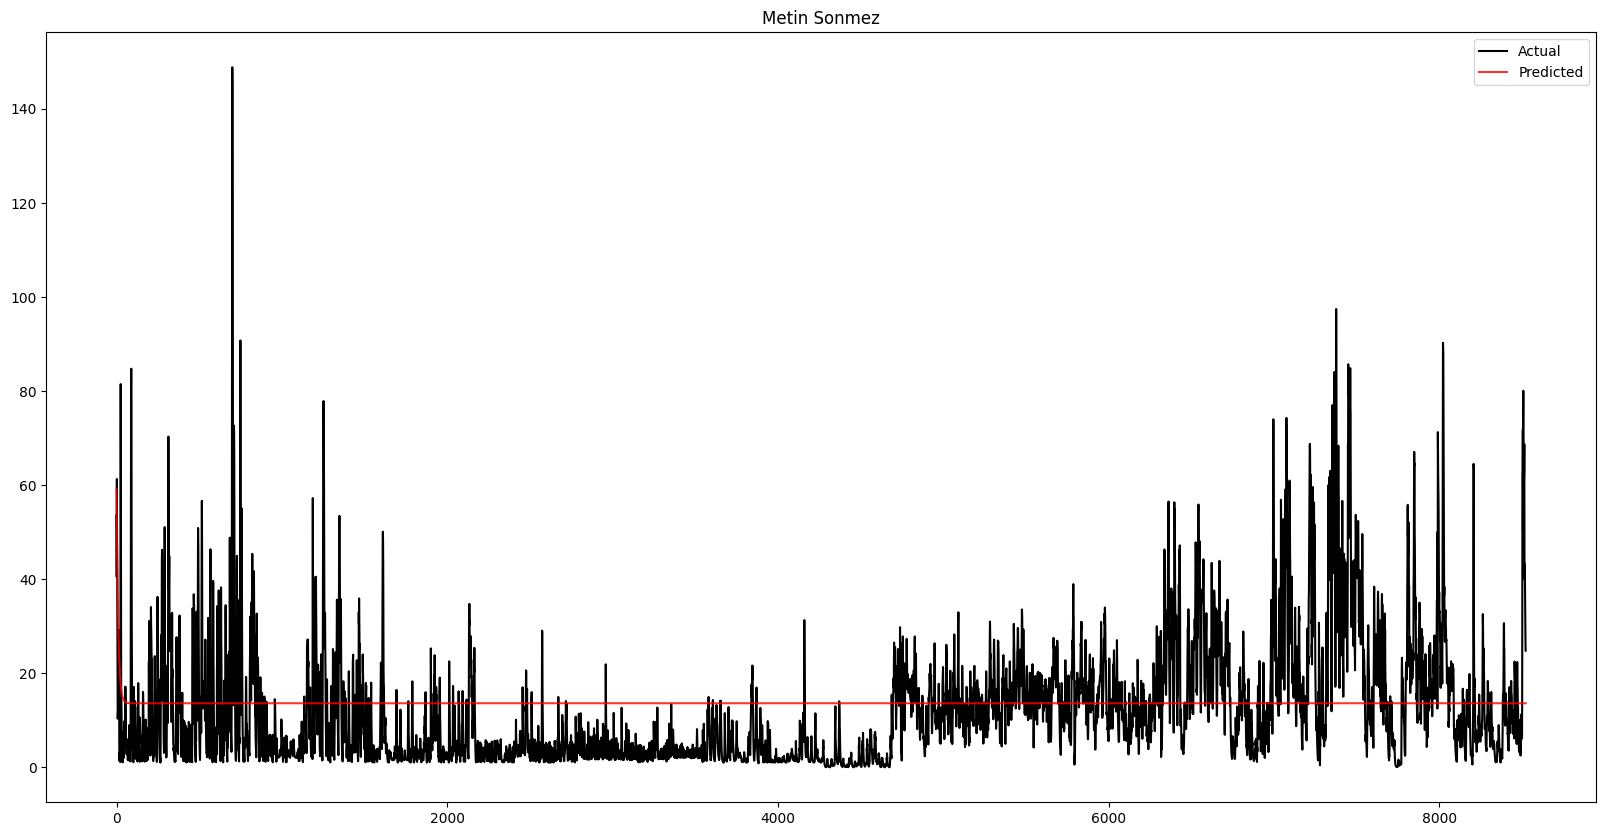

In [ ]:
plt.figure(figsize=(20,10))


plt.plot(filtered_testY, color='black', label='Actual')
plt.plot(filtered_testPredict, color='red', alpha=0.8 ,label='Predicted')
plt.legend()
plt.title("Metin Sonmez")

plt.show()